In [68]:
#Import all needed libraries
import csv
import sys, os, re
import time
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import butter, lfilter, find_peaks
from itertools import cycle
import matplotlib.patches as mpatches

import warnings

In [69]:
#Import filepath and obtain dataframe
file_path = r'C:\Users\jgx7497\Documents\BME 390-3\Data Processing Code\fuzzy-invention\log_01.csv'
df = pd.read_csv(file_path)
df

,Time(ms),Acc_x,Acc_y,Acc_z,Gyro_x,Gyro_y,Gyro_z,CO2
0,10,-0.973,-0.102,-0.184,5.725,-1.641,-0.947,0
1,20,-0.989,-0.133,-0.224,6.344,-0.893,0.229,0
2,30,-1.012,-0.103,-0.265,5.641,-0.115,0.344,0
3,40,-0.968,-0.114,-0.198,4.458,-1.511,-0.168,0
4,50,-0.984,-0.114,-0.212,5.931,0.282,0.595,363
...,...,...,...,...,...,...,...,...
36939,369400,-0.996,-0.135,-0.162,-1.237,-4.992,-0.145,565
36940,369410,-0.993,-0.130,-0.172,-1.252,-7.198,-0.298,0
36941,369420,-0.986,-0.131,-0.163,-0.527,-6.756,-0.336,0
36942,369430,-0.973,-0.137,-0.162,-0.328,-6.771,-0.473,0


As you can see, only some rows (around every 4) have a CO2 value. This is as our accelerometer measures at 100 Hz while our CO2 sensor measures at 20 Hz. To help with data anlysis, we will only consider the rows with an associated CO2 value.

In [70]:
#Filter the dataframe and reset its index
df_filtered = df[df['CO2']!=0]
df_filtered.reset_index(drop=True, inplace=True)

#Change the time column to be in seconds
df_filtered['Time(ms)'] = df_filtered['Time(ms)'] / 1000
df_filtered.rename(columns={'Time(ms)': 'Time(s)'}, inplace=True)

#Retreive all arrays
time_array = df_filtered['Time(s)']
print(time_array)
co2_signal = df_filtered['CO2']
acc_x = df_filtered['Acc_x']
acc_y = df_filtered['Acc_y']
acc_z = df_filtered['Acc_z']
gyro_x = df_filtered['Gyro_x']
gyro_y = df_filtered['Gyro_y']
gyro_z = df_filtered['Gyro_z']

0         0.05
1         0.10
2         0.15
3         0.20
4         0.25
         ...  
7383    369.20
7384    369.25
7385    369.30
7386    369.35
7387    369.40
Name: Time(s), Length: 7388, dtype: float64


C:\Users\jgx7497\AppData\Local\Temp\ipykernel_12836\3621611368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Time(ms)'] = df_filtered['Time(ms)'] / 1000
C:\Users\jgx7497\AppData\Local\Temp\ipykernel_12836\3621611368.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns={'Time(ms)': 'Time(s)'}, inplace=True)


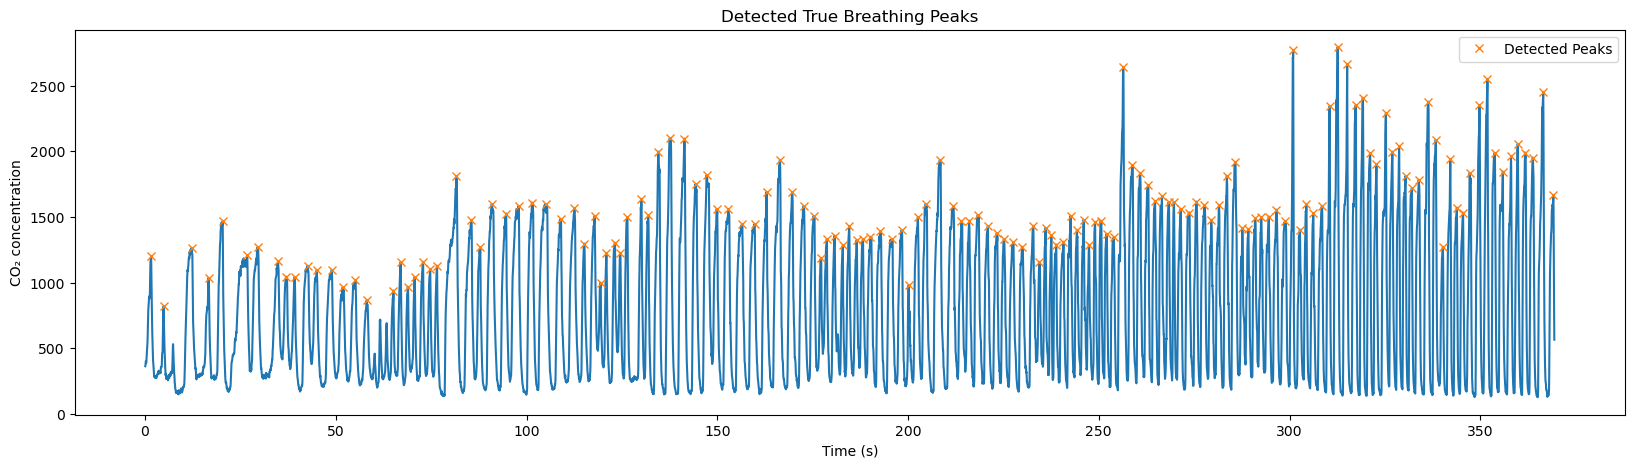

In [71]:
#1. Detect CO2 signal peaks and verify them
prominence_value = 500 #Adjust based on data
peaks, _ = find_peaks(co2_signal, distance=15, prominence=prominence_value)
#distance = 15 used as a conservative value for breahts due to exersize

#2. Plot to verify peak detection
plt.figure(figsize=(20, 5))  # Wider figure for stretched x-axis
plt.plot(time_array, co2_signal)
plt.plot(time_array.iloc[peaks], co2_signal.iloc[peaks], "x", label="Detected Peaks")
plt.xlabel('Time (s)')
plt.ylabel('CO₂ concentration')
plt.title('Detected True Breathing Peaks')
plt.legend()
plt.show()

In [72]:
def calculate_global_bpm(peaks: np.ndarray, total_duration_sec: float) -> float:
    """A simple function to calculate the global (overall) breaths per minute
    Args:
        peaks: an array of sample indices from find_peaks (scipy)
        total_duration_sec: the total duration of the trial
    Returns:
        bpm: breaths per minute throughout the entire trial"""
    total_breaths = len(peaks)
    bpm = (total_breaths/total_duration_sec)
    return bpm

def calculate_instant_bpm(peaks: np.ndarray, sampling_rate: int):
    """Computes the instantaneous bpm throughout the trial
        Args:
            peaks: an array of sample indices from find_peaks (scipy)
            sampling_rate: the sampling rate of the CO2 sensor in Hz
        Returns:
            bpm_inst, peak_times[1;]: BPMs and their associated times"""
    peak_times = peaks / sampling_rate
    intervals = np.diff(peak_times)
    bpm_inst = 60 / intervals
    return bpm_inst, peak_times[1:]

In [73]:
#Print out global BPM
duration_sec = (time_array.iloc[-1] - time_array.iloc[0]) / 60
bpm_total = calculate_global_bpm(peaks, duration_sec)
print(f"Global Breaths per Minute: {bpm_total:.2f}")

Global Breaths per Minute: 24.69


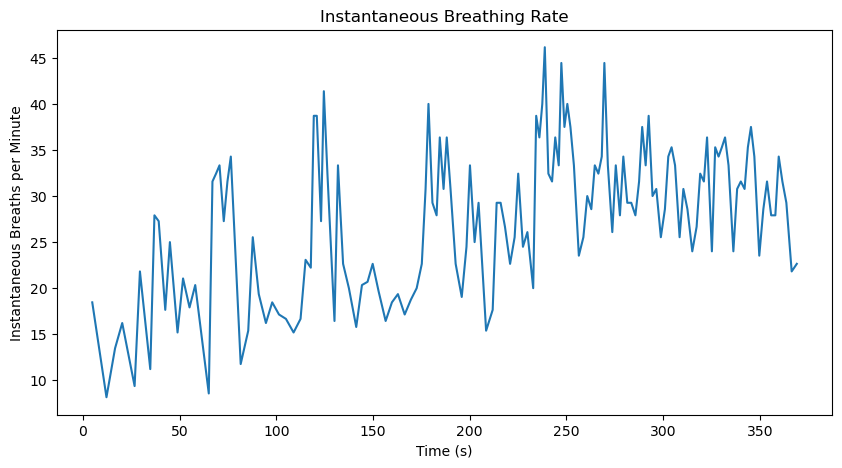

In [74]:
#Plot instantaneous BPM
plt.figure(figsize=(10,5))
instant_bpm, peak_times = calculate_instant_bpm(peaks=peaks, sampling_rate=20)
plt.plot(peak_times, instant_bpm)
plt.xlabel('Time (s)')
plt.ylabel('Instantaneous Breaths per Minute')
plt.title('Instantaneous Breathing Rate')
plt.show()


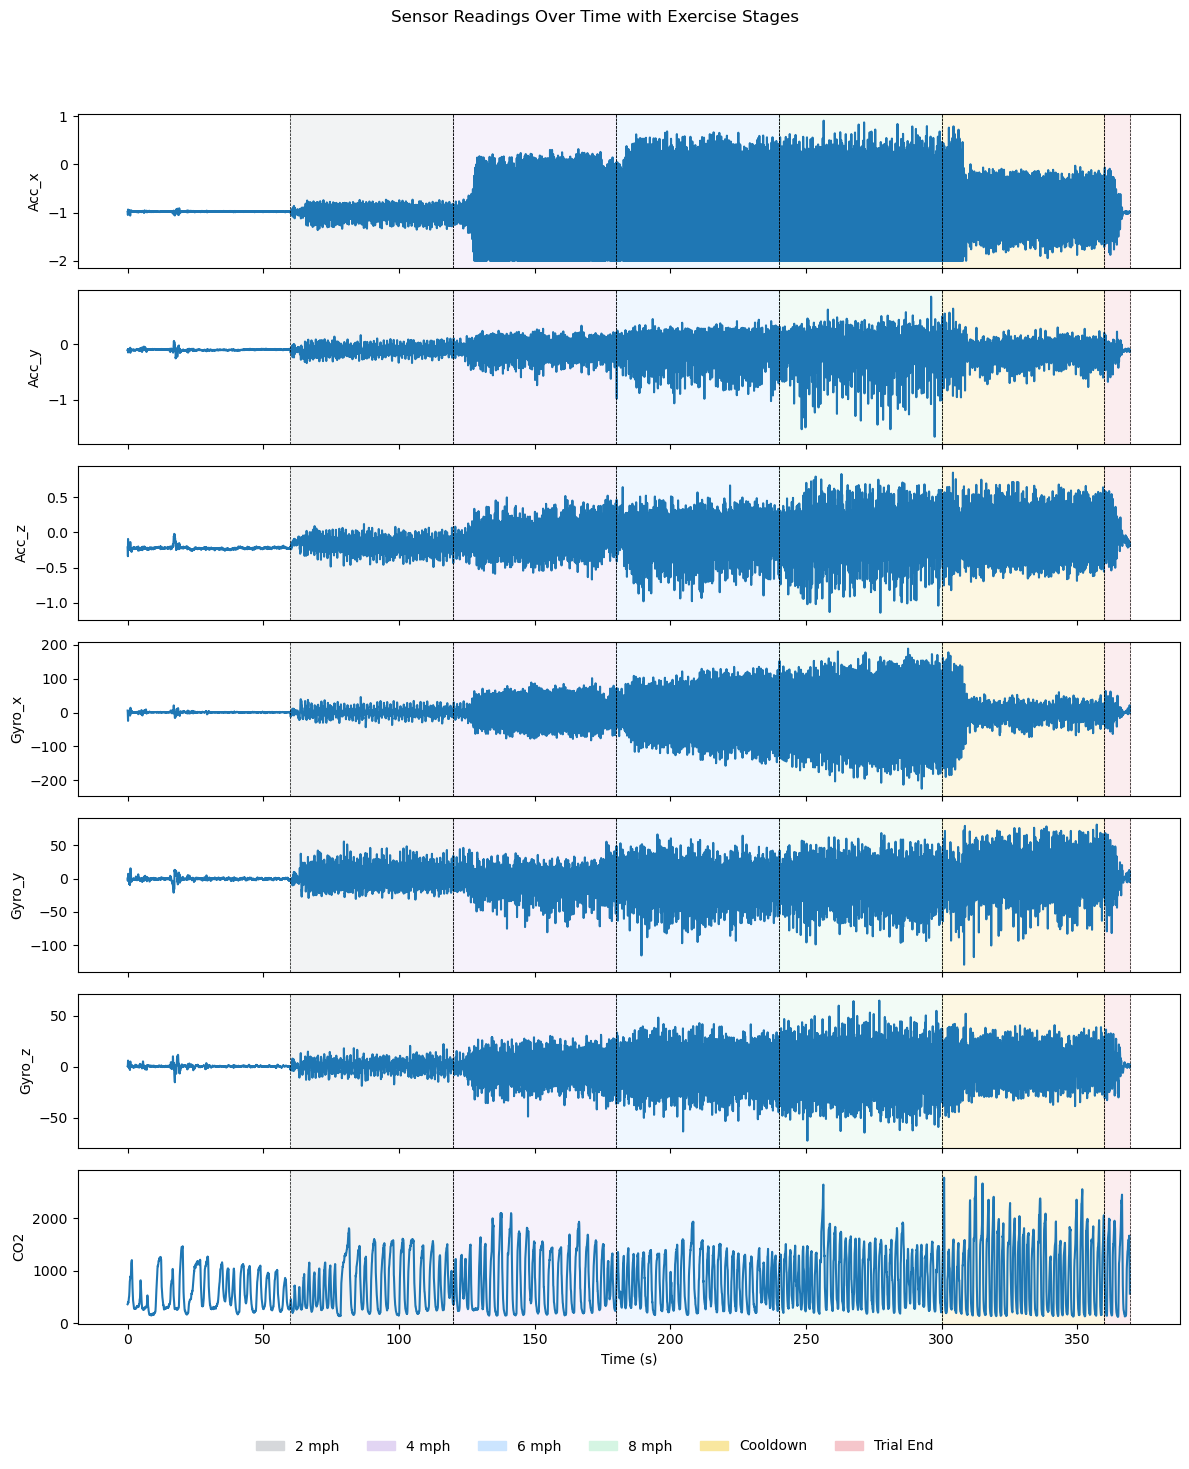

In [79]:
#Large figure that plots all seven features with time

#Define treadmill trial dividers !!!(this changes per trial)!!!
stage_starts = [60, 120, 180, 240, 300, 360] #1 min rest, then 2 min stages
stage_ends = [120, 180, 240, 300, 360, time_array.iloc[-1]] # corresponding ends

#Define features and plot
features = ['Acc_x', 'Acc_y', 'Acc_z', 'Gyro_x', 'Gyro_y', 'Gyro_z', 'CO2']
fig, axs = plt.subplots(len(features), 1, figsize=(12,14), sharex=True)

#Define colors for bacground shading and associated labels
stage_labels = ['2 mph', '4 mph', '6 mph', '8 mph', 'Cooldown', 'Trial End']
stage_colors = ['#d0e0e3', '#c9daf8', '#b6d7a8', '#a2c4c9', '#b4a7d6', '#f4cccc']

#For loop to plot graphs
for i, feature in enumerate(features):
    axs[i].plot(time_array, df_filtered[feature], label=feature)
    axs[i].set_ylabel(feature)

    # Shade exercise stages
    for j in range(len(stage_starts)):
        color = next(colors)
        axs[i].axvspan(stage_starts[j], stage_ends[j], color=color, alpha=0.3)
    
    # Draw divider lines
    for t in stage_starts + stage_ends:
        axs[i].axvline(x=t, color='black', linestyle='--', linewidth=0.5)

#Add legend and plot
axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.suptitle("Sensor Readings Over Time with Exercise Stages", y=1.02)
legend_patches = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, stage_labels)]
fig.legend(handles=legend_patches, loc='lower center', ncol=len(stage_labels), bbox_to_anchor=(0.5, -0.02), frameon=False)
plt.tight_layout(rect=[0, 0.04, 1, 0.98])  # leave space at bottom for legend
plt.show()
plt.show()